In [1]:
import numpy
import jax
from matplotlib import pyplot as plt
from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap

mred = u'#d62728' 
mgreen = u'#2ca02c'
mblue = u'#1f77b4' 

## DTD Parameters

In [2]:
A=2.11; beta=-1.13; tp=0.04

## DIFFSTAR SFH
Use an example galaxy that has been parameterized by DIFFSTAR

In [3]:
from diffmah.monte_carlo_halo_population import mc_halo_population

T0 = 13.8
tarr = numpy.linspace(0.1, T0, 200)

logmhpop = numpy.zeros(10) + 12.0
halopop = mc_halo_population(tarr, T0, logmhpop)

# Collect mah_params into array of shape (n_halos, 4)
mah_params_pop = numpy.array((halopop.log_mah[:, -1], halopop.lgtc, halopop.early_index, halopop.late_index)).T

## Supernova Rate

### Real SFH 1

In [4]:
from sn_diffstar.utils import *

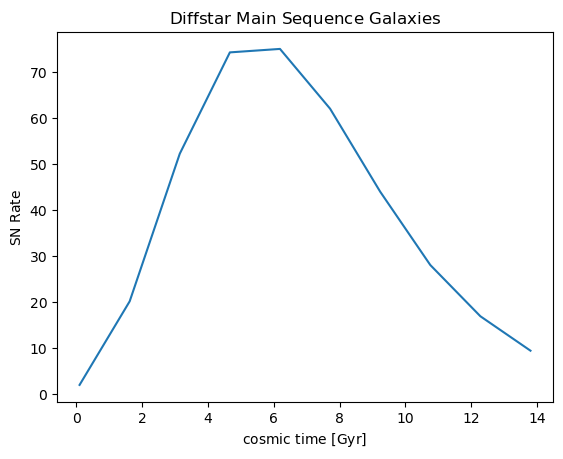

In [5]:
t0=jnp.linspace(0.1, 13.8, 10)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0, SNR_t0(t0, A, beta, tp, mah_params_pop[0,:]))
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

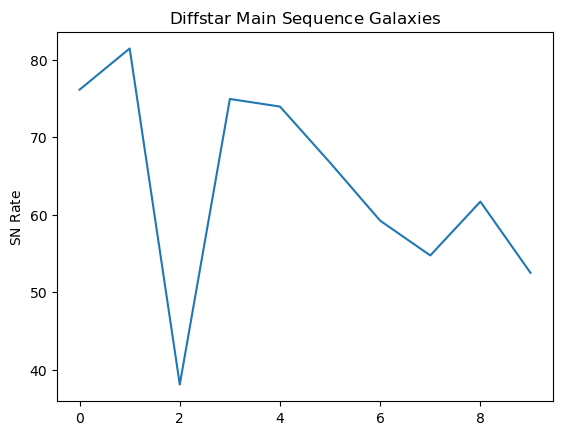

In [6]:
fig, ax = plt.subplots(1, 1)
__=ax.plot(SNR_mah(5, A, beta, tp, mah_params_pop))
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

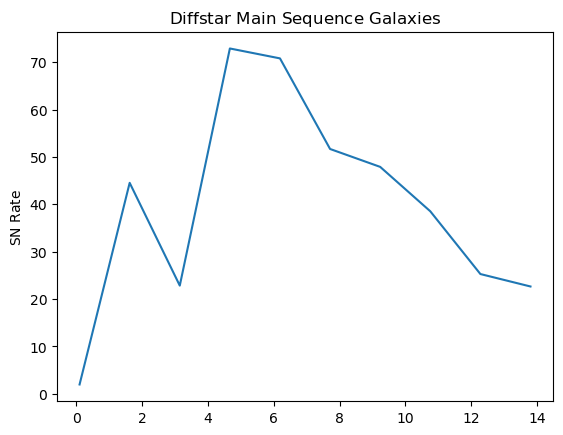

In [7]:
t0=jnp.linspace(0.1, 13.8, 10)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0, SNR_gal(t0, A, beta, tp, mah_params_pop))
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

In [8]:
SNR_t0_mah  = jjit(vmap(SNR_mah,  in_axes=(0, None, None, None, None)))

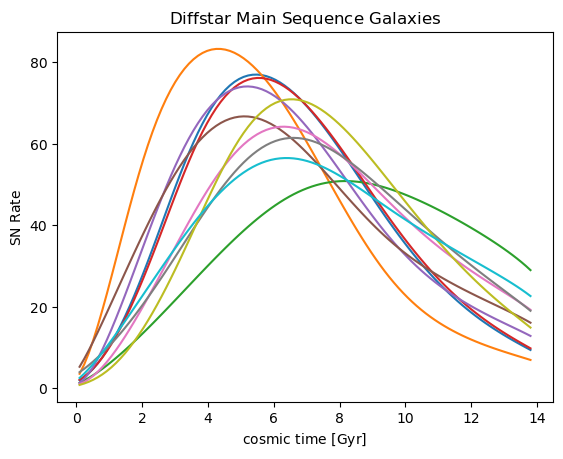

In [9]:
t0=jnp.linspace(0.1, 13.8, 100)
fig, ax = plt.subplots(1, 1)
__=ax.plot(t0, SNR_t0_mah(t0, A, beta, tp, mah_params_pop))
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel = ax.set_title(r'${\rm Diffstar\ Main\ Sequence\ Galaxies}$')
ylabel = ax.set_ylabel(r'${\rm SN\ Rate}$')

### Dummy SFH

In [10]:
@jjit
# in log(tau) units
def SNR_kernel(logtau, t0, M, A, beta, tp):
    tau = jnp.exp(logtau)
    return DTD(tau-t0, A, beta, tp)*SFH(tau, M)*tau

In [11]:
SNR_kernel_vmap = jjit(vmap(SNR_kernel, in_axes=(0, None, None, None, None, None)))

In [12]:
@jjit
def SNR(t0, M, A, beta, tp):
    logtf=jnp.log(12.)
    logtaus = jnp.linspace(jnp.log(t0), logtf, 1000)
    kernel = SNR_kernel_vmap(logtaus, t0, M, A, beta, tp)
    return jnp.trapz(kernel,logtaus)

In [ ]:
SNR_vmap = jjit(vmap(SNR, in_axes=(0, None, None, None, None)))

In [ ]:
from ..src import temp

In [ ]:
import sn_diffstar

## Delay time distribution (DTD) Eq. 6 of https://academic.oup.com/mnras/article/506/3/3330/6318383?login=false

In [ ]:
@jjit
## tau    (Gyr)
## tp      (Gyr)
## A   (1e-13 M^{-1}_{sun} yr^{-1}
##
##  Nominal values A=2.11; beta=-1.13; tp=0.04

def DTD(tau, A, beta, tp):
    return jax.lax.cond(tau < tp, lambda a: 0., lambda a : a[0]*jnp.power(a[1],a[2]), [A, tau, beta])

In [ ]:
DTD_vmap = jjit(vmap(DTD, in_axes=(0, None, None, None)))

In [ ]:
tau = jnp.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1)
__=ax.plot(tau, DTD_vmap(tau, A, beta, tp))